In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import keras
import h5py
import utils
import numpy as np
import matplotlib.pyplot as plt
#import atlas_mpl_style
#plt.style.use('ggplot')
from collections import namedtuple
import yaml

Using TensorFlow backend.


In [2]:
import genconfig
from train_MDN import train_nn, mixture_density_loss
Option = namedtuple("MyStruct", "training_input training_output validation_fraction outFile network_type \
                    config structure learning_rate regularizer epochs")

# One Particle

In [3]:
with h5py.File('NNinput_pos1_training.h5', 'r') as hf:  
    #x_train = hf['train_data_x'][:]
    #y_train = hf['train_data_y'][:]
    x_valid = hf['valid_data_x'][:]
    y_valid = hf['valid_data_y'][:]

#### Locally Trained Model

In [4]:
ModelFile = "Trained/pos1_06_16_1142"
model = tf.keras.models.load_model(ModelFile, custom_objects={'abs' : tf.keras.backend.abs,
                                                                        'loss' : mixture_density_loss(nb_components=1)})
model.load_weights('Trained/pos1_best.h5')
#model.load_weights('weights_pos1.h5')

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [5]:
pred = model.predict(x_valid)

In [6]:
pred_mean = pred[:,1:3]
pred_std = 1/np.sqrt(pred[:,3:5])

### Residuals

In [7]:
x_res = pred_mean[:,0] - y_valid[:,0]
y_res = pred_mean[:,1] - y_valid[:,1]
x_res_mean = np.average(x_res)
y_res_mean = np.average(y_res)
x_res_rms = np.std(pred_mean[:,0])
y_res_rms = np.std(pred_mean[:,1])
#x_res_rms = np.average(pred_std[:,0])
#y_res_rms = np.average(pred_std[:,1])

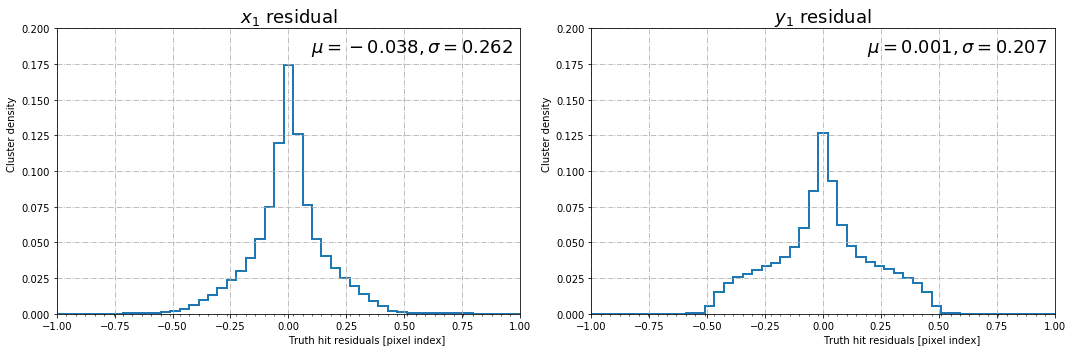

In [8]:
xlim = [-1, 1]
ylim = [0, 0.2]
nbins = np.linspace(xlim[0],xlim[1],50)
norm_weights=np.ones(len(pred_mean[:,0])) / len(pred_mean[:,0])
nparticles = int(pred_mean.shape[1]/2)
fig, ax = plt.subplots(nparticles, 2, sharey=False,sharex=True, tight_layout=True, figsize=[15,5*nparticles])
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].hist(x_res,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
ax[0].title.set_text('$x_1$ residual')
ax[0].title.set_fontsize(18)
ax[0].set_xlabel('Truth hit residuals [pixel index]', horizontalalignment='left')
ax[0].set_ylabel('Cluster density', horizontalalignment='left')
ax[0].grid(True, linestyle='-.')
ax[0].set_xticks(nbins,minor=True)
ax[0].text(ax[0].get_xlim()[1]*0.97, ax[0].get_ylim()[1]*0.97,
           '$\mu = {:.3f}, \sigma = {:.3f}$'.format(x_res_mean, x_res_rms),
           verticalalignment='top',
           horizontalalignment='right',
           fontsize=18)
ax[1].hist(y_res,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
ax[1].set_ylim(ylim)
ax[1].title.set_text('$y_1$ residual')
ax[1].title.set_fontsize(18)
ax[1].set_xlabel('Truth hit residuals [pixel index]', horizontalalignment='left')
ax[1].set_ylabel('Cluster density', horizontalalignment='left')
ax[1].grid(True, linestyle='-.')
ax[1].text(ax[0].get_xlim()[1]*0.97, ax[0].get_ylim()[1]*0.97,
           '$\mu = {:.3f}, \sigma = {:.3f}$'.format(y_res_mean, y_res_rms),
           verticalalignment='top',
           horizontalalignment='right',
           fontsize=18)

plt.savefig('Eval/1particleResiduals.png')
plt.show()
plt.close()


#font = {'family': 'serif',
#        'style' : 'italic',
#        'size': 20
#        }
#ax[1].text(ax[0].get_xlim()[0]*0.97, ax[0].get_ylim()[1]*0.97,
#           'ATLAS',
#           verticalalignment='top',
#           horizontalalignment='left',
#           fontdict=font,
#           usetex=True
#          )


### Pulls

In [9]:
np.average(pred_std[:,0]) - np.std(pred_mean[:,0])

-0.0296164

In [10]:
x_pull = x_res/pred_std[:,0]
y_pull = y_res/pred_std[:,1]
x_pull_mean = np.average(x_pull)
y_pull_mean = np.average(y_pull)
x_pull_std = np.average(x_res_rms/pred_std[:,0])
y_pull_std = np.average(y_res_rms/pred_std[:,1])
#x_pull_std = np.std(pred_mean[:,0]/pred_std[:,0])
#x_pull_std = np.average(pred_std[:,0]/x_res_rms)
#y_pull_std = np.average(pred_std[:,1]/y_res_rms)

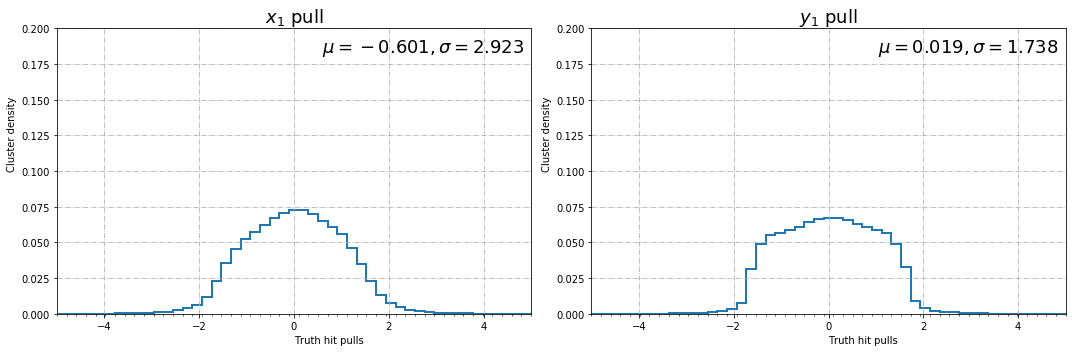

In [11]:
xlim = [-5, 5]
ylim = [0, 0.2]
nbins = np.linspace(xlim[0],xlim[1],50)

norm_weights=np.ones(len(pred_mean[:,0])) / len(pred_mean[:,0])
nparticles = int(pred_mean.shape[1]/2)
fig, ax = plt.subplots(nparticles, 2, sharey=False,sharex=True, tight_layout=True, figsize=[15,5*nparticles])
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].hist(x_pull,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
ax[0].title.set_text('$x_1$ pull')
ax[0].title.set_fontsize(18)
ax[0].set_xlabel('Truth hit pulls', horizontalalignment='left')
ax[0].set_ylabel('Cluster density', horizontalalignment='left')
ax[0].grid(True, linestyle='-.')
ax[0].set_xticks(nbins,minor=True)
ax[0].text(ax[0].get_xlim()[1]*0.97, ax[0].get_ylim()[1]*0.97,
           '$\mu = {:.3f}, \sigma = {:.3f}$'.format(x_pull_mean, x_pull_std),
           verticalalignment='top',
           horizontalalignment='right',
           fontsize=18)
ax[1].hist(y_pull,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
ax[1].set_ylim(ylim)
ax[1].title.set_text('$y_1$ pull')
ax[1].title.set_fontsize(18)
ax[1].set_xlabel('Truth hit pulls', horizontalalignment='left')
ax[1].set_ylabel('Cluster density', horizontalalignment='left')
ax[1].grid(True, linestyle='-.')
ax[1].text(ax[0].get_xlim()[1]*0.97, ax[0].get_ylim()[1]*0.97,
           '$\mu = {:.3f}, \sigma = {:.3f}$'.format(y_pull_mean, y_pull_std),
           verticalalignment='top',
           horizontalalignment='right',
           fontsize=18)
plt.savefig('Eval/1particlePulls.png')
plt.show()
plt.close()

# Two Particles

In [12]:
with h5py.File('NNinput_pos2_training.h5', 'r') as hf:  
    #x_train = hf['train_data_x'][:]
    #y_train = hf['train_data_y'][:]
    x_valid = hf['valid_data_x'][:]
    y_valid = hf['valid_data_y'][:]

#### Locally Trained Model

In [13]:
ModelFile = "Trained/pos2_06_15_2358"
model = tf.keras.models.load_model(ModelFile, custom_objects={'abs' : tf.keras.backend.abs,
                                                                        'loss' : mixture_density_loss(nb_components=1)})
model.load_weights('Trained/pos2_06_04_0556_best.h5')
#model.load_weights('weights_pos1.h5')

In [14]:
pred = model.predict(x_valid)

In [15]:
pred_mean = np.hstack((pred[0][:,1:3], pred[1][:,1:3]))
pred_std = 1/np.sqrt(np.hstack((pred[0][:,3:5], pred[1][:,3:5])))

### Residuals

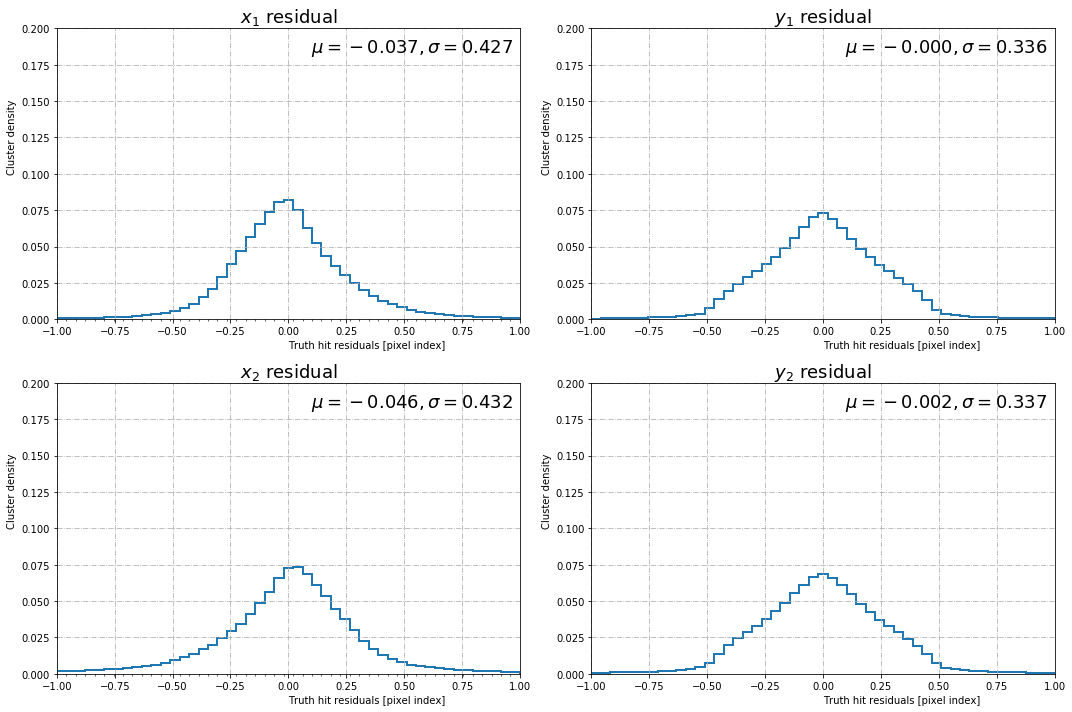

In [16]:
xlim = [-1, 1]
ylim = [0, 0.2]
nbins = np.linspace(xlim[0],xlim[1],50)
norm_weights=np.ones(len(pred_mean[:,0])) / len(pred_mean[:,0])
nparticles = int(pred_mean.shape[1]/2)
fig, ax = plt.subplots(nparticles,2,sharey=False,sharex=False,tight_layout=True, figsize=[15,5*nparticles])
for i in range(0,nparticles):
    x_res = pred_mean[:,i*2] - y_valid[:,i*2]
    y_res = pred_mean[:,i*2+1] - y_valid[:,i*2+1]
    x_res_mean = np.average(x_res)
    y_res_mean = np.average(y_res)
    x_res_rms = np.std(pred_mean[:,i*2])
    y_res_rms = np.std(pred_mean[:,i*2+1])
    ax[i][0].set_xlim(xlim)
    ax[i][0].set_ylim(ylim)
    ax[i][0].hist(x_res,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][0].title.set_text('$x_{}$ residual'.format(i+1))
    ax[i][0].title.set_fontsize(18)
    ax[i][0].set_xlabel('Truth hit residuals [pixel index]', horizontalalignment='left')
    ax[i][0].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][0].grid(True, linestyle='-.')
    ax[i][0].set_xticks(nbins,minor=True)
    ax[i][0].text(ax[i][0].get_xlim()[1]*0.97, ax[i][0].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(x_res_mean, x_res_rms),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
    ax[i][1].hist(y_res,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][1].set_xlim(xlim)
    ax[i][1].set_ylim(ylim)
    ax[i][1].title.set_text('$y_{}$ residual'.format(i+1))
    ax[i][1].title.set_fontsize(18)
    ax[i][1].set_xlabel('Truth hit residuals [pixel index]', horizontalalignment='left')
    ax[i][1].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][1].grid(True, linestyle='-.')
    ax[i][1].text(ax[i][1].get_xlim()[1]*0.97, ax[i][1].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(y_res_mean, y_res_rms),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
plt.savefig('Eval/2particleResiduals.png')
plt.show()
plt.close()

### Pulls

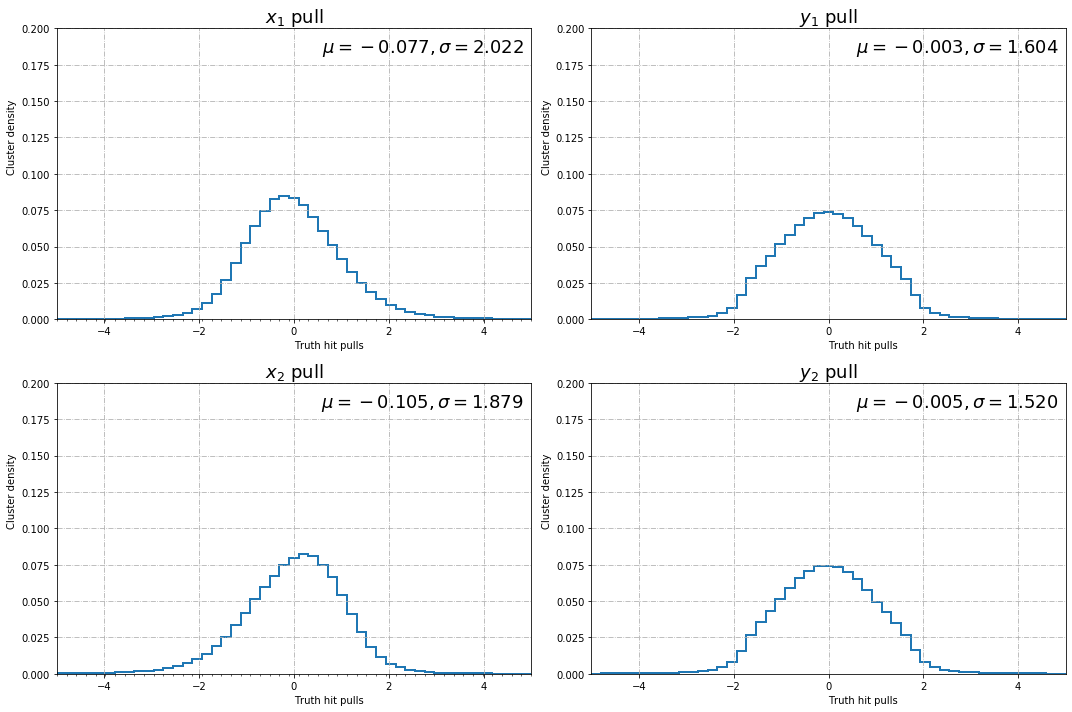

In [17]:
xlim = [-5, 5]
ylim = [0, 0.2]
nbins = np.linspace(xlim[0],xlim[1],50)
norm_weights=np.ones(len(pred_mean[:,0])) / len(pred_mean[:,0])
nparticles = int(pred_mean.shape[1]/2)
fig, ax = plt.subplots(nparticles,2,sharey=False,sharex=False,tight_layout=True, figsize=[15,5*nparticles])
for i in range(0,nparticles):
    x_res = pred_mean[:,i*2] - y_valid[:,i*2]
    y_res = pred_mean[:,i*2+1] - y_valid[:,i*2+1]
    x_res_mean = np.average(x_res)
    y_res_mean = np.average(y_res)
    x_res_rms = np.std(pred_mean[:,i*2])
    y_res_rms = np.std(pred_mean[:,i*2+1])
    x_pull = x_res/pred_std[:,i*2]
    y_pull = y_res/pred_std[:,i*2+1]
    x_pull_mean = np.average(x_pull)
    y_pull_mean = np.average(y_pull)
    x_pull_std = np.average(x_res_rms/pred_std[:,i*2])
    y_pull_std = np.average(y_res_rms/pred_std[:,i*2+1])
    ax[i][0].set_xlim(xlim)
    ax[i][0].set_ylim(ylim)
    ax[i][0].hist(x_pull,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][0].title.set_text('$x_{}$ pull'.format(i+1))
    ax[i][0].title.set_fontsize(18)
    ax[i][0].set_xlabel('Truth hit pulls', horizontalalignment='left')
    ax[i][0].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][0].grid(True, linestyle='-.')
    ax[i][0].set_xticks(nbins,minor=True)
    ax[i][0].text(ax[i][0].get_xlim()[1]*0.97, ax[i][0].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(x_pull_mean, x_pull_std),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
    #ax[i][0].plot(nbins, norm.pdf(nbins, loc=x_pull_mean, scale=x_pull_std))
    ax[i][1].hist(y_pull,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][1].set_xlim(xlim)
    ax[i][1].set_ylim(ylim)
    ax[i][1].title.set_text('$y_{}$ pull'.format(i+1))
    ax[i][1].title.set_fontsize(18)
    ax[i][1].set_xlabel('Truth hit pulls', horizontalalignment='left')
    ax[i][1].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][1].grid(True, linestyle='-.')
    ax[i][1].text(ax[i][1].get_xlim()[1]*0.97, ax[i][1].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(y_pull_mean, y_pull_std),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
plt.savefig('Eval/2particlePulls.png')
plt.show()
plt.close()

# Three Particles

In [18]:
with h5py.File('NNinput_pos3_training.h5', 'r') as hf:  
    #x_train = hf['train_data_x'][:]
    #y_train = hf['train_data_y'][:]
    x_valid = hf['valid_data_x'][:]
    y_valid = hf['valid_data_y'][:]

#### Locally Trained Model

In [19]:
ModelFile = "Trained/pos3_06_15_1624"
model = tf.keras.models.load_model(ModelFile, custom_objects={'abs' : tf.keras.backend.abs,
                                                                        'loss' : mixture_density_loss(nb_components=1)})
model.load_weights('Trained/pos3_06_15_1624_best.h5')
#model.load_weights('weights_pos1.h5')

In [20]:
pred = model.predict(x_valid)

In [21]:
pred_mean = np.hstack((pred[0][:,1:3], pred[1][:,1:3], pred[2][:,1:3]))
pred_std = 1/np.sqrt(np.hstack((pred[0][:,3:5], pred[1][:,3:5], pred[2][:,3:5])))

### Residuals

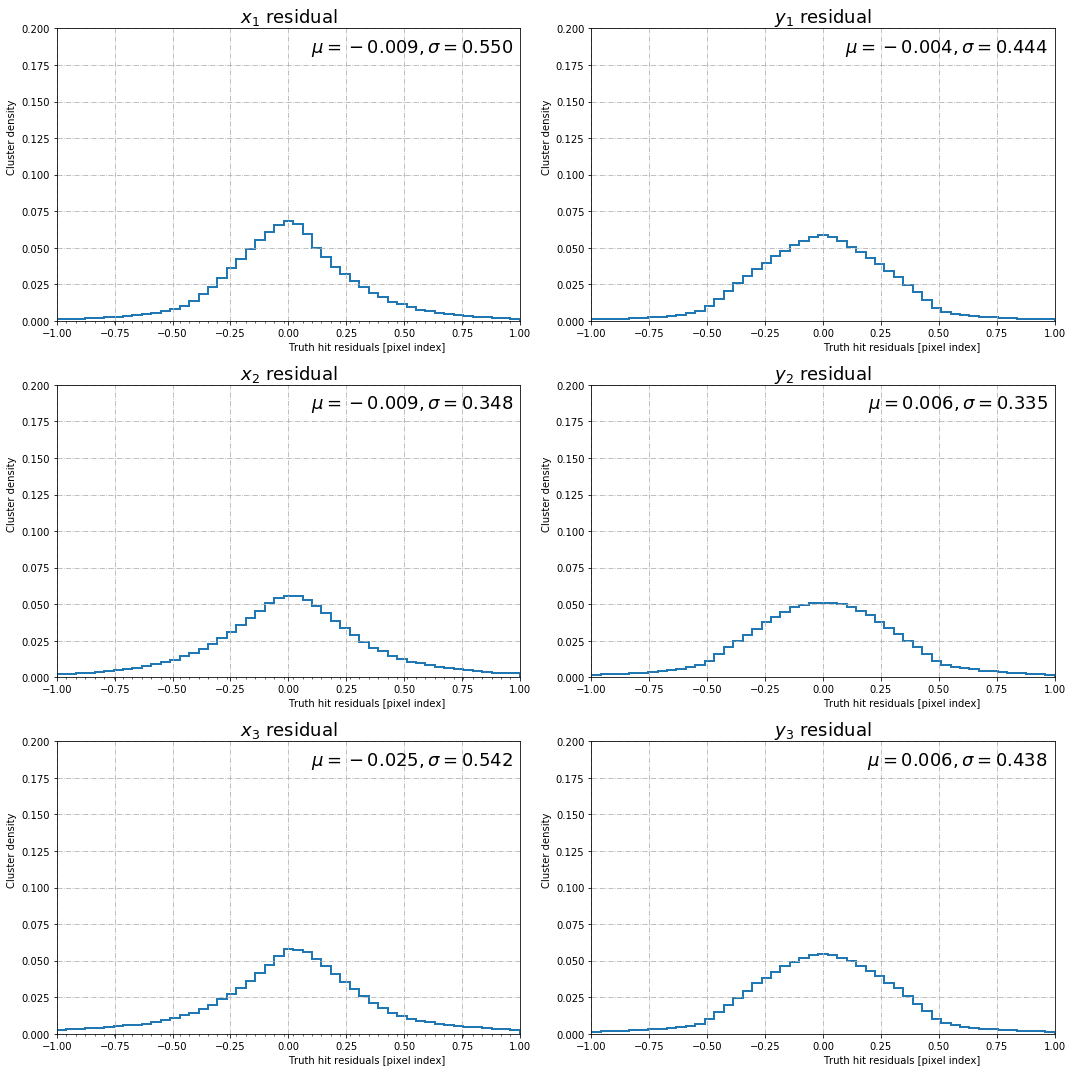

In [22]:
xlim = [-1, 1]
ylim = [0, 0.2]
nbins = np.linspace(xlim[0],xlim[1],50)
norm_weights=np.ones(len(pred_mean[:,0])) / len(pred_mean[:,0])
nparticles = int(pred_mean.shape[1]/2)
fig, ax = plt.subplots(nparticles,2,sharey=False,sharex=False,tight_layout=True, figsize=[15,5*nparticles])
for i in range(0,nparticles):
    x_res = pred_mean[:,i*2] - y_valid[:,i*2]
    y_res = pred_mean[:,i*2+1] - y_valid[:,i*2+1]
    x_res_mean = np.average(x_res)
    y_res_mean = np.average(y_res)
    x_res_rms = np.std(pred_mean[:,i*2])
    y_res_rms = np.std(pred_mean[:,i*2+1])
    ax[i][0].set_xlim(xlim)
    ax[i][0].set_ylim(ylim)
    ax[i][0].hist(x_res,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][0].title.set_text('$x_{}$ residual'.format(i+1))
    ax[i][0].title.set_fontsize(18)
    ax[i][0].set_xlabel('Truth hit residuals [pixel index]', horizontalalignment='left')
    ax[i][0].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][0].grid(True, linestyle='-.')
    ax[i][0].set_xticks(nbins,minor=True)
    ax[i][0].text(ax[i][0].get_xlim()[1]*0.97, ax[i][0].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(x_res_mean, x_res_rms),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
    ax[i][1].hist(y_res,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][1].set_xlim(xlim)
    ax[i][1].set_ylim(ylim)
    ax[i][1].title.set_text('$y_{}$ residual'.format(i+1))
    ax[i][1].title.set_fontsize(18)
    ax[i][1].set_xlabel('Truth hit residuals [pixel index]', horizontalalignment='left')
    ax[i][1].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][1].grid(True, linestyle='-.')
    ax[i][1].text(ax[i][1].get_xlim()[1]*0.97, ax[i][1].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(y_res_mean, y_res_rms),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
plt.savefig('Eval/3particleResiduals.png')
plt.show()
plt.close()

### Pulls

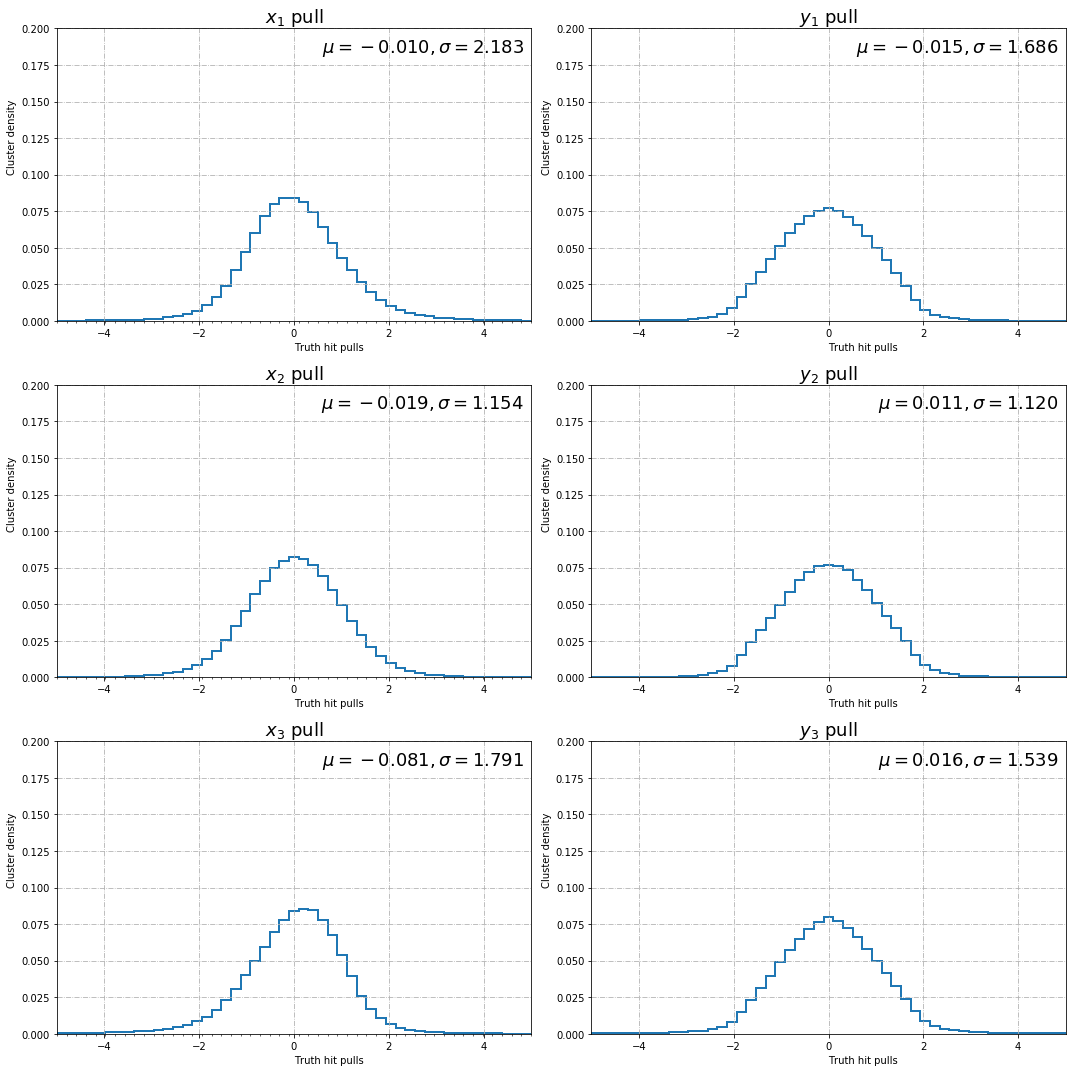

In [23]:
xlim = [-5, 5]
ylim = [0, 0.2]
nbins = np.linspace(xlim[0],xlim[1],50)
norm_weights=np.ones(len(pred_mean[:,0])) / len(pred_mean[:,0])
nparticles = int(pred_mean.shape[1]/2)
fig, ax = plt.subplots(nparticles,2,sharey=False,sharex=False,tight_layout=True, figsize=[15,5*nparticles])
for i in range(0,nparticles):
    x_res = pred_mean[:,i*2] - y_valid[:,i*2]
    y_res = pred_mean[:,i*2+1] - y_valid[:,i*2+1]
    x_res_mean = np.average(x_res)
    y_res_mean = np.average(y_res)
    x_res_rms = np.std(pred_mean[:,i*2])
    y_res_rms = np.std(pred_mean[:,i*2+1])
    x_pull = x_res/pred_std[:,i*2]
    y_pull = y_res/pred_std[:,i*2+1]
    x_pull_mean = np.average(x_pull)
    y_pull_mean = np.average(y_pull)
    x_pull_std = np.average(x_res_rms/pred_std[:,i*2])
    y_pull_std = np.average(y_res_rms/pred_std[:,i*2+1])
    ax[i][0].set_xlim(xlim)
    ax[i][0].set_ylim(ylim)
    ax[i][0].hist(x_pull,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][0].title.set_text('$x_{}$ pull'.format(i+1))
    ax[i][0].title.set_fontsize(18)
    ax[i][0].set_xlabel('Truth hit pulls', horizontalalignment='left')
    ax[i][0].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][0].grid(True, linestyle='-.')
    ax[i][0].set_xticks(nbins,minor=True)
    ax[i][0].text(ax[i][0].get_xlim()[1]*0.97, ax[i][0].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(x_pull_mean, x_pull_std),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
    #ax[i][0].plot(nbins, norm.pdf(nbins, loc=x_pull_mean, scale=x_pull_std))
    ax[i][1].hist(y_pull,  bins=nbins, weights=norm_weights, density=False, histtype='step', linewidth=2)
    ax[i][1].set_xlim(xlim)
    ax[i][1].set_ylim(ylim)
    ax[i][1].title.set_text('$y_{}$ pull'.format(i+1))
    ax[i][1].title.set_fontsize(18)
    ax[i][1].set_xlabel('Truth hit pulls', horizontalalignment='left')
    ax[i][1].set_ylabel('Cluster density', horizontalalignment='left')
    ax[i][1].grid(True, linestyle='-.')
    ax[i][1].text(ax[i][1].get_xlim()[1]*0.97, ax[i][1].get_ylim()[1]*0.97,
               '$\mu = {:.3f}, \sigma = {:.3f}$'.format(y_pull_mean, y_pull_std),
               verticalalignment='top',
               horizontalalignment='right',
               fontsize=18)
plt.savefig('Eval/3particlePulls.png')
plt.show()
plt.close()

In [24]:
x_pull_std = np.std(x_pull)
x_pull_std

51.89130955377731

In [25]:
.09*.5*.5*1

0.0225